# 4. Network Graphs

Graphs may not be the most aesthetic visualizations, but they too can tell a story. For example, graphs are perfect to show the interactions between different items. Multiplex's graph visualizations help you not just plot graphs, but also explain them.

Sometimes called networks, graphs are made up of nodes. Nodes can be connected with each other using edges, which can be both directed and undirected. Multiplex uses matplotlib's scatter and plotting functions to draw nodes and lines, which means that you can style nodes and edges any way you like.

In this notebook, we will go through examples of drawing different kinds of networks from scratch.

> Multiplex uses `networkx` to draw graphs, which means that the package has to be installed. You can learn more about `networkx` [here](https://networkx.github.io/).

In [1]:
%load_ext autoreload
%autoreload 2

import importlib
import matplotlib.pyplot as plt
from networkx import edge_betweenness_centrality
from networkx.algorithms import centrality, community, shortest_paths
import networkx as nx
import os
import pandas as pd
import re
import sys

path = sys.path[0]
path = os.path.join(path, "..")
if path not in sys.path:
    sys.path.insert(1, path)

The first network is the [Marvel Universe Social Network](https://www.kaggle.com/csanhueza/the-marvel-universe-social-network). Yes, even superheros have friends.

This dataset is made up of pairs of superheroes that appeared together in the same comic. Unfortunately, it is _huge_, so we filter out superhero connections that do not appear at least 50 times together.

In [2]:
df = pd.read_csv('data/the-marvel-universe-social-network/hero-network.csv')
df.columns = ('source', 'target')
df = df.groupby(['source', 'target']).size().reset_index()
df.columns = ('source', 'target', 'frequency')
df = df[df['frequency'] > 50]
df = df[df['source'] != df['target']]
df.sort_values(by='frequency', ascending=False)

,source,target,frequency
142513,PATRIOT/JEFF MACE,MISS AMERICA/MADELIN,1267
124772,MISS AMERICA/MADELIN,PATRIOT/JEFF MACE,627
196026,THING/BENJAMIN J. GR,HUMAN TORCH/JOHNNY S,382
85445,HUMAN TORCH/JOHNNY S,MR. FANTASTIC/REED R,366
196250,THING/BENJAMIN J. GR,MR. FANTASTIC/REED R,365
...,...,...,...
109528,LOCKHEED,NIGHTCRAWLER/KURT WA,51
18258,BLACK PANTHER/T'CHAL,THOR/DR. DONALD BLAK,51
84219,HULK/DR. ROBERT BRUC,NIGHTHAWK II/KYLE RI,51
213969,"WATSON-PARKER, MARY","OSBORN, HARRY",51


Multiplex draws networks from `networkx` graphs. Therefore before drawing the Marvel Universe superhero network, we convert the data into a graph. If you have never used `networkx`, worry not. It is extremely simple to create graphs from nodes or edges.

For the sake of the example, we make the dataset smaller by focusing on the 50 most popular superheroes in the dataset.

In [3]:
G = nx.convert_matrix.from_pandas_edgelist(df, 'source', 'target')
degree = sorted(G.degree(), key=lambda hero: hero[1], reverse=True)
top = [ hero for hero, neighbours in degree if neighbours > 2 ][:50]
G = G.subgraph(top)
print(f"{ len(G.nodes) } nodes, { len(G.edges) } edges")

50 nodes, 229 edges


As soon as we create the graph, plotting it is as simple as calling the drawable's `draw_graph` method, using `s` to control the node size. The styling for nodes and edges can be passed separately as dictionaries using the `node_style` and `edge_style` parameters.

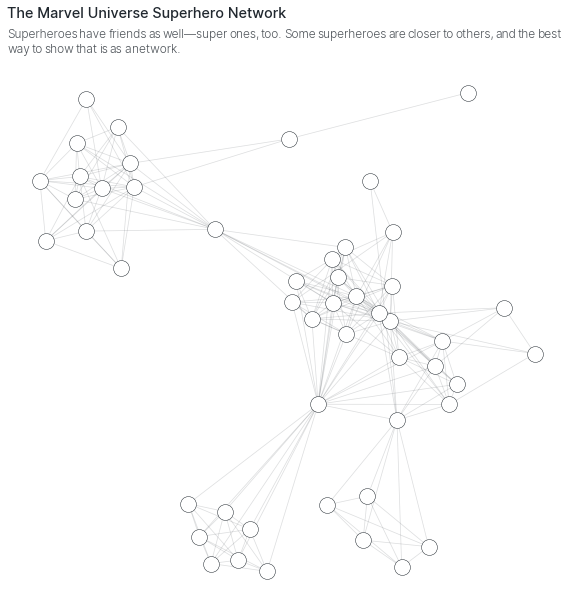

In [5]:
from multiplex import drawable
drawable = importlib.reload(drawable)

plt.style.use(os.path.join(sys.path[0], '..', 'styles', "modern.style"))

figure = plt.figure(figsize=(10, 10))
viz = drawable.Drawable(figure)
node_style = { 'color': 'C2', 'edgecolor': 'C0', 'linewidth': 0.5, 's': 250 }
edge_style = { 'color': 'C0', 'linewidth': 0.75, 'alpha': 0.15 }
nodes, edges = viz.draw_graph(G, k=0.5, seed=12,
                              node_style=node_style, edge_style=edge_style)

viz.set_title('The Marvel Universe Superhero Network', loc='left')
viz.set_caption("""Superheroes have friends as well—super ones, too.
                   Some superheroes are closer to others, and the best way to show that is as a network.""")
plt.show()

Some superheroes are closer than others.

In [6]:
def most_central_edge(graph):
    """
    Find the most central edge in the given graph.
    
    :param graph: The graph on which the algorithm operates.
    :type graph: :class:`~networkx.Graph`
    
    :return: The most central edge, made up of the source and edge nodes.
    :rtype: tuple
    """

    centrality = edge_betweenness_centrality(graph)
    return max(centrality, key=centrality.get)
    
communities = community.girvan_newman(G, most_valuable_edge=most_central_edge)
partitions = list(next(communities))
while len(partitions) < len(G.nodes) ** (1/2.):
    partitions = list(next(communities))
partitions = [ partition for partition in partitions if len(partition) > 1 ]
partitions = sorted(partitions, key=len, reverse=True)
print(partitions)

[{'JARVIS, EDWIN ', 'THING/BENJAMIN J. GR', 'CAPTAIN AMERICA', 'BLACK WIDOW/NATASHA ', 'ANT-MAN/DR. HENRY J.', 'SHE-HULK/JENNIFER WA', 'IRON MAN/TONY STARK ', 'HERCULES [GREEK GOD]', 'INVISIBLE WOMAN/SUE ', 'HUMAN TORCH/JOHNNY S', 'WONDER MAN/SIMON WIL', "BLACK PANTHER/T'CHAL", 'THOR/DR. DONALD BLAK', 'QUICKSILVER/PIETRO M', 'SCARLET WITCH/WANDA ', 'VISION ', 'WASP/JANET VAN DYNE ', 'HAWK', 'MR. FANTASTIC/REED R'}, {'HAVOK/ALEX SUMMERS ', 'STORM/ORORO MUNROE S', 'ICEMAN/ROBERT BOBBY ', 'COLOSSUS II/PETER RA', 'MARVEL GIRL/JEAN GRE', 'ROGUE /', 'WOLVERINE/LOGAN ', 'SHADOWCAT/KATHERINE ', 'BEAST/HENRY &HANK& P', 'NIGHTCRAWLER/KURT WA', 'CYCLOPS/SCOTT SUMMER', 'PROFESSOR X/CHARLES ', 'ANGEL/WARREN KENNETH'}, {'FANDRAL [ASGARDIAN]', 'ODIN [ASGARDIAN]', 'LOKI [ASGARDIAN]', 'HOGUN [ASGARDIAN]', 'BALDER [ASGARDIAN]', 'SIF', 'VOLSTAGG'}, {'DAREDEVIL/MATT MURDO', 'WATSON-PARKER, MARY ', 'THOMPSON, EUGENE FLA', 'SPIDER-MAN/PETER PAR', 'JAMESON, J. JONAH', 'PARKER, MAY', 'LEEDS, BETTY BRANT'}]


The two largest partitions belong to the Avengers and the X-Men. A network too can tell a story. Next, we override the styling of the Avengers and the X-Men to make them pop. Any styling options added to nodes and edges as the `style` attribute overrides any default styles.

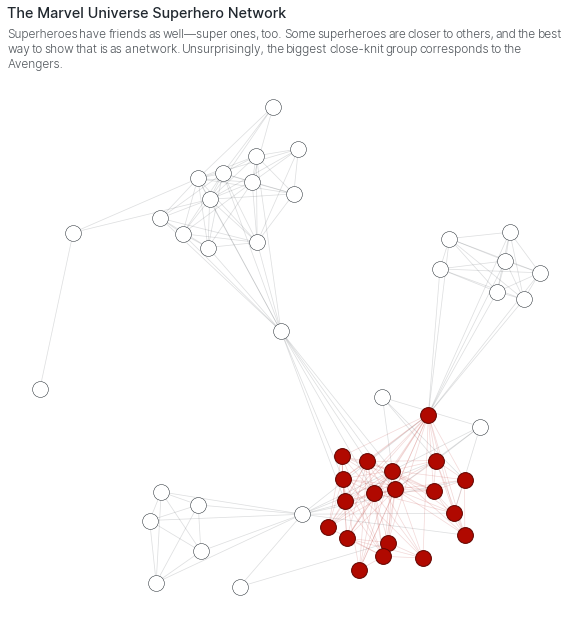

In [14]:
from multiplex import drawable
drawable = importlib.reload(drawable)

plt.style.use(os.path.join(sys.path[0], '..', 'styles', "modern.style"))

"""
Color the Avengers' nodes and edges red.
"""
pattern = re.compile('^(.+)?[,\/\[].+?$')
l = 0
for node in G.nodes:
    G.nodes[node]['style'] = { }
for node in partitions[0]:
    G.nodes[node]['style'] = { 'color': '#B00900', 'edgecolor': '#620500', 'linewidth': 1 }
    edges = [ (source, target) for (source, target) in G.edges(node)
             if target in partitions[0] ]
    for edge in edges:
        G.edges[edge]['style'] = { 'alpha': 0.15, 'color': '#B00900' }

figure = plt.figure(figsize=(10, 10))
viz = drawable.Drawable(figure)
node_style = { 'color': 'C2', 'edgecolor': 'C0', 'linewidth': 0.5, 's': 250 }
edge_style = { 'color': 'C0', 'linewidth': 0.75, 'alpha': 0.15 }
nodes, edges = viz.draw_graph(G, k=0.59, seed=20,
                              node_style=node_style, edge_style=edge_style)
viz.set_title('The Marvel Universe Superhero Network', loc='left')
viz.set_caption("""Superheroes have friends as well—super ones, too.
                   Some superheroes are closer to others, and the best way to show that is as a network.
                   Unsurprisingly, the biggest close-knit group corresponds to the Avengers.""")
plt.show()

In [15]:
S = G.subgraph(partitions[0])
node_centrality = centrality.eigenvector_centrality(S)
center = max(node_centrality, key=node_centrality.get)
print(f"Most central superhero: { center }")
distances = { node: len(shortest_paths.generic.shortest_path(G, center, node)) for node in G.nodes }
distances

Most central superhero: CAPTAIN AMERICA


{'FANDRAL [ASGARDIAN]': 3,
 'ODIN [ASGARDIAN]': 3,
 'JARVIS, EDWIN ': 2,
 'THING/BENJAMIN J. GR': 2,
 'WATSON-PARKER, MARY ': 3,
 'HOGUN [ASGARDIAN]': 3,
 'SHADOWCAT/KATHERINE ': 4,
 'BEAST/HENRY &HANK& P': 2,
 'CANNONBALL II/SAM GU': 4,
 'SUB-MARINER/NAMOR MA': 2,
 'CYCLOPS/SCOTT SUMMER': 3,
 'CAPTAIN AMERICA': 1,
 'ANGEL/WARREN KENNETH': 3,
 'HAVOK/ALEX SUMMERS ': 4,
 'DAREDEVIL/MATT MURDO': 3,
 'BLACK WIDOW/NATASHA ': 2,
 'ANT-MAN/DR. HENRY J.': 2,
 'STORM/ORORO MUNROE S': 3,
 'SHE-HULK/JENNIFER WA': 2,
 'JAMESON, J. JONAH': 3,
 'IRON MAN/TONY STARK ': 2,
 'COLOSSUS II/PETER RA': 4,
 'MARVEL GIRL/JEAN GRE': 3,
 'WOLVERINE/LOGAN ': 3,
 'BALDER [ASGARDIAN]': 3,
 'HERCULES [GREEK GOD]': 2,
 'INVISIBLE WOMAN/SUE ': 2,
 'NIGHTCRAWLER/KURT WA': 4,
 'VOLSTAGG': 3,
 'PARKER, MAY': 3,
 'PROFESSOR X/CHARLES ': 3,
 'HUMAN TORCH/JOHNNY S': 2,
 'WONDER MAN/SIMON WIL': 2,
 "BLACK PANTHER/T'CHAL": 2,
 'THOR/DR. DONALD BLAK': 2,
 'LOKI [ASGARDIAN]': 3,
 'HULK/DR. ROBERT BRUC': 2,
 'ICEMAN/ROBERT BO

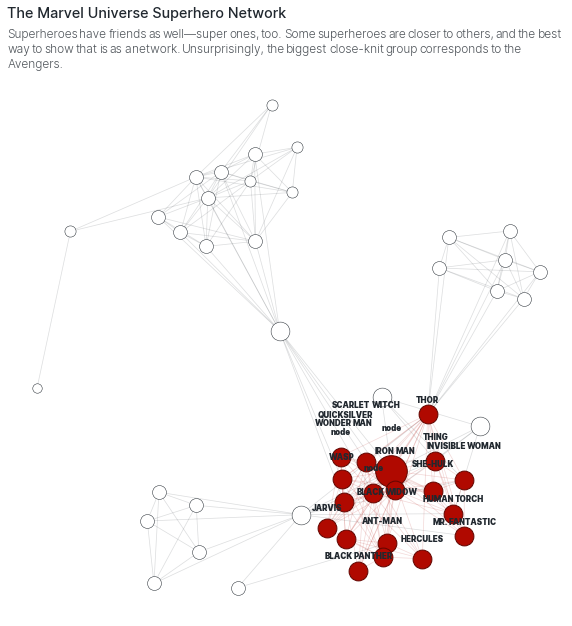

In [18]:
from multiplex import drawable
drawable = importlib.reload(drawable)

plt.style.use(os.path.join(sys.path[0], '..', 'styles', "modern.style"))

"""
Color the Avengers' nodes and edges red.
"""
pattern = re.compile('^(.+)?[,\/\[].+?$')
l = 0
for node in G.nodes:
    G.nodes[node]['style'] = { 's': 1000 * (1 / distances[node] ** 1.5) }

for node in partitions[0]:
    G.nodes[node]['style']['color'] = '#B00900'
    G.nodes[node]['style']['edgecolor'] = '#620500'
    G.nodes[node]['style']['linewidth'] = 1
    G.nodes[node]['name'] = pattern.findall(node)[0] if pattern.findall(node) else 'node'
    edges = [ (source, target) for (source, target) in G.edges(node)
             if target in partitions[0] ]
    for edge in edges:
        G.edges[edge]['style'] = { 'alpha': 0.15, 'color': '#B00900' }

figure = plt.figure(figsize=(10, 10))
viz = drawable.Drawable(figure)
node_style = { 'color': 'C2', 'edgecolor': 'C0', 'linewidth': 0.5 }
edge_style = { 'color': 'C0', 'linewidth': 0.75, 'alpha': 0.15 }
nodes, edges = viz.draw_graph(G, k=0.59, seed=20,
                              node_style=node_style, edge_style=edge_style)
viz.set_title('The Marvel Universe Superhero Network', loc='left')
viz.set_caption("""Superheroes have friends as well—super ones, too.
                   Some superheroes are closer to others, and the best way to show that is as a network.
                   Unsurprisingly, the biggest close-knit group corresponds to the Avengers.""")
plt.show()

You can learn more about graph visualizations, including functionality that was not covered in this tutorial, on [Multiplex's documentation site](https://nicholasmamo.github.io/multiplex-plot/graph.html).